# Vulnerability analysis

This notebook contains analysis of vulnerabilities in Common Criteria certificates. 

In [1]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from sec_certs.cert_rules import cc_rules

sns.set_style("whitegrid")
sns.set_palette("deep")
sns.set_context("notebook")  # Set to "paper" for use in paper :)

import itertools
import warnings
from pathlib import Path

from sec_certs.dataset import CCDataset, CPEDataset, CVEDataset, CCDatasetMaintenanceUpdates
from sec_certs.utils.pandas import (
    compute_cve_correlations,
    compute_maintenances_that_come_after_vulns,
    discover_sar_families,
    expand_df_with_cve_cols,
    filter_to_cves_within_validity_period,
    get_sar_level_from_set,
    get_top_n_cwes,
    move_fixing_mu_to_directory,
    prepare_cwe_df,
)

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

RESULTS_DIR = Path("./results")
RESULTS_DIR.mkdir(exist_ok=True)

## Retrieve necessary objects from sec-certs

In [2]:
# Local instantiation
# dset: CCDataset = CCDataset.from_web_latest()
# #dset.process_maintenance_updates() # Run this only once, can take ~10 minutes to finnish, fully processes mainten#ance updates
# main_dset = CCDatasetMaintenanceUpdates.from_json(dset.mu_dataset_path)
# cve_dset: CVEDataset = dset._prepare_cve_dataset()
# cpe_dset: CPEDataset = dset._prepare_cpe_dataset()

# Remote instantiation
dset: CCDataset = CCDataset.from_web_latest()
main_dset: CCDatasetMaintenanceUpdates = CCDatasetMaintenanceUpdates.from_web_latest()
cve_dset: CVEDataset = CVEDataset.from_web()

Building CVEDataset from jsons: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.38it/s]


### Dataset preprocessing

- Loads `CCDataset` into pandas DataFrame
- Expands it with various maintenance-related columns
- Expands it with various CVE-related columns

In [3]:
df = dset.to_pandas()

if "n_maintenances" not in df.columns:
    n_maintenances = main_dset.get_n_maintenances_df()
    df = pd.concat([df, n_maintenances], axis="columns")

if "maintenance_dates" not in df.columns:
    main_dates = main_dset.get_maintenance_dates_df()
    df = pd.concat([df, main_dates], axis="columns")

# Expand DataFrame with CVEs that affect some certificate
cves = list(itertools.chain.from_iterable(x.heuristics.related_cves for x in dset if x.heuristics.related_cves))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict  # Limit cve_dset to CVEs relevant to some certificate

df = expand_df_with_cve_cols(df, cve_dset)

df_cves_within_validity_period = filter_to_cves_within_validity_period(
    df.loc[(df.not_valid_before.notnull()) & (df.not_valid_after.notnull())].copy(), cve_dset
)
df_cves_within_validity_period = expand_df_with_cve_cols(df_cves_within_validity_period, cve_dset)

df_cpe_rich = df.loc[~df.cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.n_cves > 0].copy()


In [4]:
# Take a look at columns related to CVEs
df.loc[
    ~df.related_cves.isna(), ["related_cves", "cve_published_dates", "earliest_cve", "worst_cve_score", "avg_cve_score"]
]


,related_cves,cve_published_dates,earliest_cve,worst_cve_score,avg_cve_score
77cfa16b7ed7975f,"{CVE-2020-3285, CVE-2020-3187, CVE-2021-1495, ...","[2020-05-06, 2020-05-06, 2021-04-29, 2019-11-0...",2019-01-24,10.0,7.085106
3dc6e1ebe7dd5584,"{CVE-2022-40707, CVE-2021-25252, CVE-2022-4070...","[2022-09-28, 2021-03-03, 2022-09-28, 2022-09-2...",2021-03-03,7.8,4.640000
b7f814ed16f2ecca,{CVE-2018-8753},[2018-08-15],2018-08-15,5.9,5.900000
c290ee3692a00006,"{CVE-2019-12256, CVE-2019-7487, CVE-2019-12261...","[2019-08-09, 2019-12-19, 2019-08-09, 2021-03-2...",2019-08-09,9.8,8.075000
4fc1208e4c800aa6,"{CVE-2017-14616, CVE-2017-14615}","[2017-09-20, 2017-09-20]",2017-09-20,7.5,6.800000
...,...,...,...,...,...
bf0f130ebce2e124,"{CVE-2007-3262, CVE-2009-2747, CVE-2009-0217, ...","[2007-06-19, 2011-10-30, 2009-07-14, 2006-10-1...",2005-11-04,10.0,5.710390
686005d0b5ff5c5c,"{CVE-2006-2342, CVE-2007-3262, CVE-2009-2747, ...","[2006-05-12, 2007-06-19, 2011-10-30, 2009-07-1...",2005-05-02,10.0,5.904348
5f1df5ad8e51ba75,"{CVE-2007-4615, CVE-2006-0419, CVE-2006-2464, ...","[2007-08-31, 2006-01-25, 2006-05-19, 2004-07-2...",2003-08-27,10.0,5.594565
ffeef32299d913d6,"{CVE-2009-0439, CVE-2008-1130}","[2009-02-24, 2008-03-04]",2008-03-04,7.2,6.900000


## Plots

- distribution of categories in CPE-rich vs. all certificates
- distribution of years in CPE-rich, CVE-rich, and all certificates
- distribution of security levels in CPE-rich, CVE-rich and all certificates
- distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates

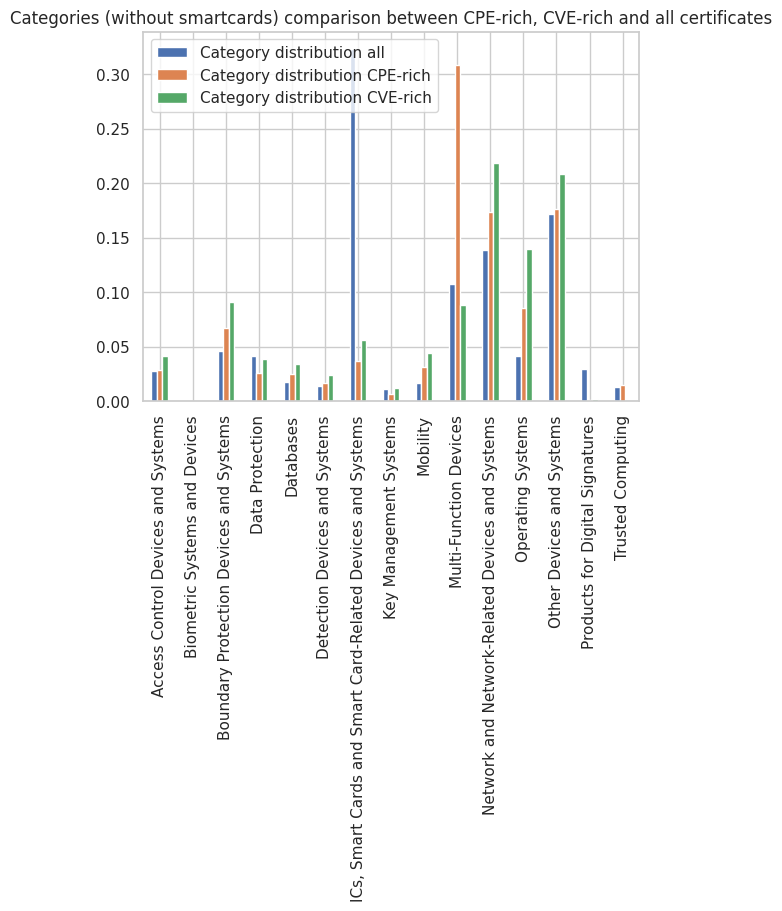

<Figure size 640x480 with 0 Axes>

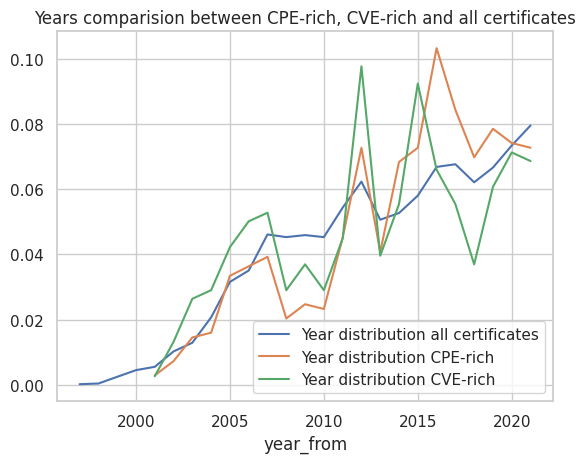

<Figure size 640x480 with 0 Axes>

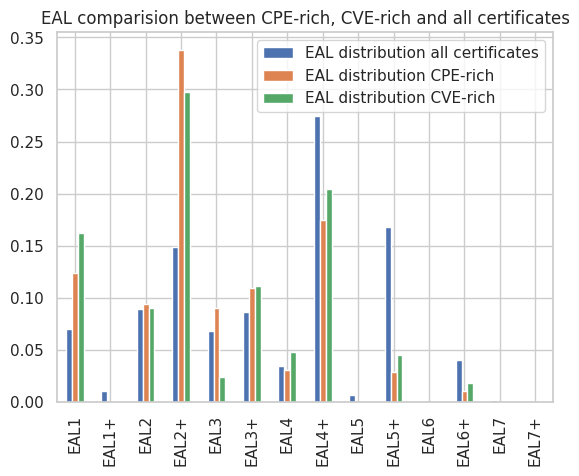

<Figure size 640x480 with 0 Axes>

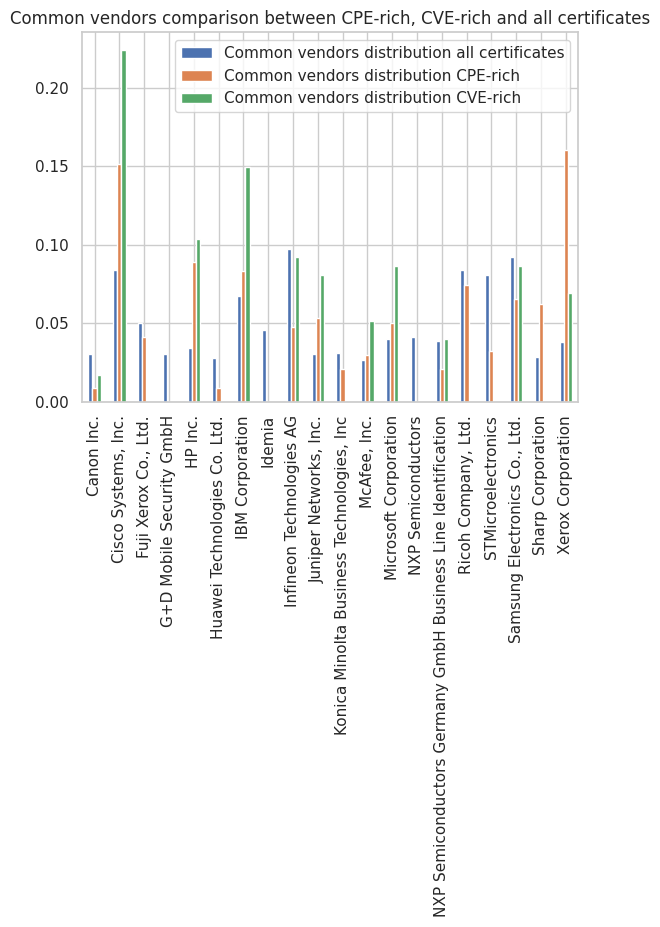

<Figure size 640x480 with 0 Axes>

In [5]:
# distribution of categories in CPE-rich vs. all certificates
categories_cpe = df_cpe_rich.category.value_counts().sort_index().rename("Category distribution CPE-rich")
categories_cve = df_cve_rich.category.value_counts().sort_index().rename("Category distribution CVE-rich")
categories_all = df.category.value_counts().sort_index().rename("Category distribution all")

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)

categories_merged.plot.bar(
    title="Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates"
)
plt.show()
plt.savefig(RESULTS_DIR / "categories.pdf", bbox_inches="tight")

# distribution of years in CPE-rich, CVE-rich, and all certificates
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename("Year distribution CPE-rich")
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename("Year distribution CVE-rich")
years_all = df.year_from.value_counts().sort_index().rename("Year distribution all certificates")

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged.index.name = "year_from"
years_merged = years_merged.loc[years_merged.index < 2022]
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title="Years comparision between CPE-rich, CVE-rich and all certificates")

plt.show()
plt.savefig(RESULTS_DIR / "cve_cpe_certs_time_evolution.pdf", bbox_inches="tight")

# distribution of security levels in CPE-rich, CVE-rich and all certificates
levels_cpe = df_cpe_rich.eal.value_counts().sort_index().rename("EAL distribution CPE-rich")
levels_cve = df_cve_rich.eal.value_counts().sort_index().rename("EAL distribution CVE-rich")
levels_all = df.eal.value_counts().sort_index().rename("EAL distribution all certificates")

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title="EAL comparision between CPE-rich, CVE-rich and all certificates")
plt.show()
plt.savefig(RESULTS_DIR / "eal_distr_all_cpes_cves.pdf", bbox_inches="tight")

# distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates
top_manufacturers = list(df.manufacturer.value_counts().head(20).index)
vendors_cpe = (
    df_cpe_rich.loc[df_cpe_rich.manufacturer.isin(top_manufacturers), "manufacturer"]
    .value_counts()
    .sort_index()
    .rename("Common vendors distribution CPE-rich")
)
vendors_cve = (
    df_cve_rich.loc[df_cve_rich.manufacturer.isin(top_manufacturers), "manufacturer"]
    .value_counts()
    .sort_index()
    .rename("Common vendors distribution CVE-rich")
)
vendors_all = (
    df.loc[df.manufacturer.isin(top_manufacturers), "manufacturer"]
    .value_counts()
    .sort_index()
    .rename("Common vendors distribution all certificates")
)

vendors_merged = pd.concat([vendors_all, vendors_cpe, vendors_cve], axis=1)
vendors_merged = vendors_merged.div(vendors_merged.sum(axis=0), axis=1)
vendors_merged.plot.bar(title="Common vendors comparison between CPE-rich, CVE-rich and all certificates")
plt.show()
plt.savefig(RESULTS_DIR / "top_vendors_vulns.pdf", bbox_inches="tight")


## Correlations between (EAL, SAR) and CVEs

In [6]:
# This limits analysis to SAR families that are popular-enough (>100 CVE-rich certs, second-most-popular value with >= 40 instances)
cve_rich = df_cves_within_validity_period.loc[df_cves_within_validity_period.related_cves.notnull()].copy()
families = discover_sar_families(cve_rich.extracted_sars)

for family in tqdm(families):
    cve_rich[family] = cve_rich.extracted_sars.map(lambda x: get_sar_level_from_set(x, family))

sars = cve_rich[families].notnull().sum().to_frame("support")
sars.index.name = "family"
sars["second_most_popular"] = sars.index.map(
    lambda x: 0 if not len(cve_rich[x].value_counts()) > 1 else cve_rich[x].value_counts().iloc[1]
)
sars = sars.loc[(sars.support >= 100) & (sars.second_most_popular >= 40)].sort_values(by="support", ascending=False)
sars["range"] = sars.index.map(lambda x: len(cve_rich[x].value_counts()))

df_corr = compute_cve_correlations(
    df_cves_within_validity_period.loc[
        df_cves_within_validity_period.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems"
    ],
    sar_families=sars.index.tolist(),
    filter_nans=False,
)
df_corr["range"] = sars["range"]
df_corr.loc["eal", "range"] = len(cve_rich.eal.cat.categories)
df_corr = (
    df_corr.sort_values(by="avg_cve_score_corr")
    .rename(index={"eal": "EAL"})
    .drop(columns=["worst_cve_score_corr", "worst_cve_pvalue"])
)
df_corr = pd.concat([df_corr.loc["EAL", :].to_frame().transpose(), df_corr.drop("EAL")])
df_corr.range = df_corr.range.astype("int")
df_corr.support = df_corr.support.astype("int")
df_corr.index.name = "EAL/SAR family"
df_corr.index = df_corr.index.map(lambda x: x.replace("_", "\_"))
df_corr.to_csv(RESULTS_DIR / "certs_without_smartcards_sar_cve_corr.csv", float_format="%.2e")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
df_corr


## Time from CVE to maintenance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE may be related to that vulnerability
- The sample size is small. Only ~40 certificates have at least one CVE and at least one Maintenance update. Out of those, only ~30 certificates have maintenance update that comes after a CVE

In [ ]:
df_main_after_vuln = compute_maintenances_that_come_after_vulns(df_cves_within_validity_period)

n_vuln_certs_wo_maintenances = df_cves_within_validity_period.loc[
    (df_cves_within_validity_period.n_cves > 0) & (df_cves_within_validity_period.n_maintenances == 0)
].shape[0]
n_vuln_certs_w_maintenances = df_cves_within_validity_period.loc[
    (df_cves_within_validity_period.n_cves > 0) & (df_cves_within_validity_period.n_maintenances > 0)
].shape[0]
n_certs_with_main_after_vuln = df_main_after_vuln.loc[df_main_after_vuln.earliest_maintenance_after_vuln.notna()].shape[
    0
]

print(
    f"Number of certificates with >0 CVEs in validity period but 0 maintenance reports: {n_vuln_certs_wo_maintenances}"
)
print(
    f"Number of certificates with >0 CVEs in validity period and >0 maintenance reports: {n_vuln_certs_w_maintenances}"
)
print(f"Number of vulnerable certificates with a maintenance report *after* CVE: {n_certs_with_main_after_vuln}")

updates_that_should_fix_vulns_path = RESULTS_DIR / "updates_that_should_fix_vulns"
updates_that_should_fix_vulns_path.mkdir(exist_ok=True)
mu_filenames = move_fixing_mu_to_directory(
    df_main_after_vuln,
    main_dset.to_pandas(),
    updates_that_should_fix_vulns_path,
    "/Users/adam/phd/projects/certificates/sec-certs/datasets/cc_04_10_2022/certs/maintenances/reports/pdf",
)


In [ ]:
df_main_after_vuln.loc[
    df_main_after_vuln.earliest_maintenance_after_vuln.notna(),
    [
        "name",
        "cpe_matches",
        "related_cves",
        "not_valid_before",
        "not_valid_after",
        "cve_published_dates",
        "maintenance_dates",
        "earliest_maintenance_after_vuln",
    ],
].to_csv("/Users/adam/Downloads/vulns_before_mu.csv")


In [ ]:
df_main_after_vuln.loc[
    df_main_after_vuln.earliest_maintenance_after_vuln.notna(),
    ["maintenance_dates", "earliest_cve", "earliest_maintenance_after_vuln"],
]


## Histogram timeline of new vulnerabilities

Shows when vulnerabilities are announced in relation to the date of certification & date of certificate expiration.

*Note*: Some certificates (especially the new ones) don't have their expiration date set yet. These are discarded from the analysis.

In [ ]:
exploded_cves = (
    df_cve_rich.explode("related_cves")
    .loc[:, ["related_cves", "not_valid_before", "not_valid_after"]]
    .rename(columns={"related_cves": "cve"})
)
exploded_cves = exploded_cves.dropna()
exploded_cves["cve_published_date"] = exploded_cves.cve.map(lambda x: cve_dset[x].published_date)

exploded_cves.not_valid_before = exploded_cves.not_valid_before.dt.normalize()
exploded_cves.not_valid_after = exploded_cves.not_valid_after.dt.normalize()
exploded_cves.cve_published_date = exploded_cves.cve_published_date.dt.tz_localize(None).dt.normalize()

exploded_cves["n_days_after_certification"] = (
    exploded_cves.cve_published_date - exploded_cves.not_valid_before
).dt.days
exploded_cves["n_days_after_expiry"] = (exploded_cves.cve_published_date - exploded_cves.not_valid_after).dt.days

plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.autolayout"] = True
figure, axes = plt.subplots(1, 2)

exploded_cves.to_csv(RESULTS_DIR / "exploded_cves.csv")

hist = sns.histplot(exploded_cves.n_days_after_certification, kde=True, ax=axes[0])
hist.set(
    xlim=(-4000, 4600),
    title="CVEs appearing n days after certification",
    xlabel="Number of days after date of certification",
    ylabel="Frequency of CVEs",
)
hist.axvline(0, color="red", linewidth="1", label="Day of certification")
hist.legend(loc="upper right")
# plt.savefig(RESULTS_DIR / "cves_n_days_after_certification.pdf", bbox_inches='tight')
# plt.show()

hist = sns.histplot(exploded_cves.n_days_after_expiry, kde=True, ax=axes[1])
hist.set(
    xlim=(-6200, 4000),
    title="CVEs appearing n days after certificate expiry date",
    xlabel="Number of days after certificate expiration",
    ylabel="Frequency of CVEs",
)
hist.axvline(0, color="red", linewidth="1", label="Day of expiration")
hist.legend(loc="upper left")
plt.savefig(RESULTS_DIR / "cves_vs_certificate_lifetime.pdf", bbox_inches="tight")
plt.show()

n_cves = exploded_cves.shape[0]
ratio_before_cert = exploded_cves.loc[exploded_cves.n_days_after_certification <= 0].shape[0] / n_cves
ratio_after_cert = exploded_cves.loc[exploded_cves.n_days_after_certification > 0].shape[0] / n_cves
print(f"Ratio of CVEs appearing before (or exactly on) certification date: {100 * ratio_before_cert:.2f}%")
print(f"Ratio of CVEs appearing after certification date: {100 * ratio_after_cert:.2f}%")


## How many CVE-rich certificates were revoked within <365 days after certification

In [ ]:
maybe_revoked = df_cve_rich.loc[
    ~df_cve_rich.not_valid_after.isna(),
    ["not_valid_before", "not_valid_after", "n_cves", "worst_cve_score", "avg_cve_score", "related_cves"],
]
maybe_revoked["validity_n_days"] = (maybe_revoked.not_valid_after - maybe_revoked.not_valid_before).dt.days
maybe_revoked = maybe_revoked.loc[maybe_revoked.validity_n_days < 365]
print(f"How many CVE-rich certificates were revoked in <365 days after certification: {maybe_revoked.shape[0]}")

df_w_validity_dates = df.loc[~df.not_valid_after.isna()].copy()
df_w_validity_dates.loc[:, "validity_n_days"] = (
    df_w_validity_dates.not_valid_after - df_w_validity_dates.not_valid_before
).dt.days
df_w_validity_dates = df_w_validity_dates.loc[df_w_validity_dates.validity_n_days < 365]
print(f"How many certificates were revoked in <365 days after certification: {df_w_validity_dates.shape[0]}")
print(
    f"How many certificates have expiry date same as certification date: {df_w_validity_dates.loc[df_w_validity_dates.not_valid_before == df_w_validity_dates.not_valid_after].shape[0]}"
)


In [ ]:
df_w_validity_dates.loc[
    :, ["name", "not_valid_before", "not_valid_after", "validity_n_days", "related_cves"]
].sort_values(by="validity_n_days", ascending=False)


## Scatterplot of CVE severity w.r.t. categories

In [ ]:
n_cves_top_20_certs = df_cve_rich.n_cves.sort_values(ascending=False).head(20)[-1]
cves = (
    df_cve_rich.loc[
        (df_cve_rich.year_from < 2022) & (df_cve_rich.n_cves < n_cves_top_20_certs) & (~df_cve_rich.eal.isna()),
        ["related_cves", "eal", "category"],
    ]
    .explode("related_cves")
    .rename(columns={"related_cves": "cve_id"})
)
cves["published_date"] = cves.cve_id.map(lambda x: cve_dset[x].published_date).dt.tz_localize(None).dt.normalize()
cves["base_score"] = cves.cve_id.map(lambda x: cve_dset[x].impact.base_score)
cves = cves.drop_duplicates()

g = sns.relplot(
    data=cves,
    x="published_date",
    y="base_score",
    hue="eal",
    col="category",
    col_wrap=3,
    height=4,
    kind="scatter",
    facet_kws={"sharey": False, "sharex": False},
    palette="viridis",
)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=60)
g.set_axis_labels("Vulnerability publish date", "Vulnerability base score")
g.tight_layout()
plt.savefig(RESULTS_DIR / "scatter_category_vs_cves.pdf", bbox_inches="tight")


## Histogram of vulnerability scores per category

In [ ]:
cves = cves.reset_index()  # See https://github.com/mwaskom/seaborn/issues/2733
g = sns.displot(
    data=cves,
    x="base_score",
    col="category",
    col_wrap=3,
    height=3,
    kind="hist",
    facet_kws={"sharey": False, "sharex": True},
)
g.set_titles("{col_name}")
# g.set_xticklabels(rotation=60)
g.set_axis_labels("Vulnerability base score", "Frequency")
g.tight_layout()
plt.savefig(RESULTS_DIR / "hist_category_vs_cve.pdf", bbox_inches="tight")


## Protection-profiles vs CVEs

Computes Pearson's correlation coefficient between number of CVEs and binary variable: Has a protection profile (1) or has not a protection profile (0)
Beware, number of supporting certificates may be quite low

In [ ]:
df_cve_rich["has_pp"] = df_cve_rich.protection_profiles.isna()
corrs = df_cve_rich.groupby("category")[["n_cves", "has_pp"]].corr().iloc[0::2, -1].droplevel(level=1)
corrs.name = "correlation"
support_counts = df_cve_rich.groupby("category").size()
support_counts.name = "n certs in category"
pp_rich_counts = df_cve_rich.loc[df_cve_rich.has_pp == True].groupby("category").size()
pp_rich_counts.name = "n certs with PP"
pp_n_cves_corr = pd.concat([corrs, support_counts, pp_rich_counts], axis=1)


In [ ]:
pp_n_cves_corr


## CWEs in vulnerable certificates

- Study distribution of [CWEs](https://cwe.mitre.org/) in vulnerable certificates. 
- Experiment mainly with distribution across categories and security level. 
- Compare our results with findings from [open-source projects](https://dl.acm.org/doi/pdf/10.1145/3133956.3134072).
- Limit only to vulns. that were disclosed in the validity period of a certificate

In [ ]:
cc_df, cwe_df = prepare_cwe_df(
    df_cves_within_validity_period.loc[df_cves_within_validity_period.n_cves > 0], cve_dset, fine_grained=True
)


In [ ]:
cc_df


In [ ]:
cwe_df


In [ ]:
# Print top-25 CWEs across dataset
top_25_cwes = get_top_n_cwes(cc_df, cwe_df, n_cwes=25)
top_25_cwes


In [ ]:
# Store top-10 CWEs into CSVs, do this also per category
CWE_DIR = RESULTS_DIR / "cwes"
CWE_DIR.mkdir(exist_ok=True)
top_25_cwes.to_csv(CWE_DIR / "top_25_cwe_overall.csv")

for cat in cc_df.category.unique():
    get_top_n_cwes(cc_df, cwe_df, category=cat).to_csv(CWE_DIR / (cat + ".csv"))

# Same for EALs
for eal in cc_df.eal.unique():
    get_top_n_cwes(cc_df, cwe_df, eal=eal).to_csv(CWE_DIR / (eal + ".csv"))


In [ ]:
# For more coarse-grained description of CVEs, one could use so-called Security Fault Patterns (SFP) clusters.
from sec_certs.utils.pandas import SFPModel

model = SFPModel.from_web()
model.search_cwe(626)  # <-- This returns Primary Cluster and Secondary cluster


## CWE evolution in time

the following plot shows how top-10 overall CWEs evolve in time. As can be seen from the plot, the distribution is quite stable except for `CWE-119`. We assume that this can be caused by favoring different CWEs for similar problems, so it does not necessarilly correspond to certain weakness being eliminated recently in the coe, but even this may be the case.

In [ ]:
cc_df.head()


In [ ]:
cc_df["vuln_year"] = cc_df.cve_id.map(lambda x: int(x.split("-")[1]))
cc_df = cc_df.loc[cc_df.vuln_year < 2022]
top_10_cwes = set(get_top_n_cwes(cc_df, cwe_df, n_cwes=10).index.tolist())
top_10_cwes = cc_df.loc[cc_df.cwe_id.isin(top_10_cwes)]
pivot = (
    top_10_cwes.groupby(["vuln_year", "cwe_id"], as_index=False)
    .size()
    .rename(columns={"size": "frequency"})
    .pivot("vuln_year", "cwe_id", "frequency")
    .fillna(0)
)
sns.lineplot(data=pivot)
plt.xlabel("Year of vulnerability")
plt.ylabel("Number of vulnerabilities")
plt.legend(title="Weakness ID")
plt.title("CWE prevalence in time")


## Print commands for LaTeX file

In [ ]:
def get_n_rules(dct):
    if isinstance(dct, list):
        return len(dct)
    if isinstance(list(dct.values())[0], dict):
        return sum([get_n_rules(x) for x in dct.values()])
    else:
        return sum([len(x) for x in dct.values()])


n_regular_expressions = get_n_rules(cc_rules)

n_all_cpes = len(cpe_dset)
n_short_cpes = len([x for x in cpe_dset if x.item_name is not None and not len(x.item_name) > 3])

n_smartcards_vulnerable = len(
    df_cve_rich.loc[df_cve_rich.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"]
)
unique_smartcard_cves = set(
    itertools.chain.from_iterable(
        df_cve_rich.loc[
            df_cve_rich.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"
        ].related_cves.tolist()
    )
)

df_cve_rich["roca"] = df_cve_rich.related_cves.map(lambda x: "CVE-2017-15361" in x)
df_cve_rich["titan"] = df_cve_rich.related_cves.map(lambda x: "CVE-2021-3011" in x)
df_cve_rich["minerva"] = df_cve_rich.related_cves.map(lambda x: "CVE-2019-15809" in x)
df_cve_rich["tmpfail"] = df_cve_rich.related_cves.map(lambda x: "CVE-2019-16863" in x)

n_roca_certs = df_cve_rich.roca.value_counts()[True]
n_titan_certs = df_cve_rich.titan.value_counts()[True]

# Compute direct RoCA references
roca_certs = set(df_cve_rich.loc[df_cve_rich.roca].index.tolist())
st = set()
report = set()

for cert in dset:
    if cert.dgst in roca_certs:
        if cert.heuristics.report_references and cert.heuristics.report_references.directly_referenced_by:
            report = report.union(cert.heuristics.report_references.directly_referenced_by)
        if cert.heuristics.st_references and cert.heuristics.st_references.directly_referenced_by:
            st = st.union(cert.heuristics.st_references.directly_referenced_by)
all_refs = st.union(report)

try:
    n_minerva_certs = df_cve_rich.minerva.value_counts()[True]
except KeyError:
    n_minerva_certs = 0

try:
    n_tmpfail_certs = df_cve_rich.tmpfail.value_counts()[True]
except KeyError:
    n_tmpfail_certs = 0

n_cves_in_validity_period = exploded_cves.loc[
    (exploded_cves.cve_published_date > exploded_cves.not_valid_before)
    & (exploded_cves.cve_published_date < exploded_cves.not_valid_after)
].shape[0]
n_cves_all = exploded_cves.shape[0]

print(f"\\newcommand{{\\numCCActiveVulnerable}}{{${df_cve_rich.loc[df_cve_rich.status == 'active'].shape[0]}$}}")
print(f"\\newcommand{{\\numCCArchivedVulnerable}}{{${df_cve_rich.loc[df_cve_rich.status == 'archived'].shape[0]}$}}")
print(
    f"\\newcommand{{\\fractionCPEShort}}{{${(100 * n_short_cpes / n_all_cpes):.2f}\%$}}  % number CPE strings with <4 characters."
)
print(f"\\newcommand{{\\numRegularExpressions}}{{${n_regular_expressions}$}}")
print(f"\\newcommand{{\\numSmartcardsVulnerable}}{{${n_smartcards_vulnerable}$}}")
print(f"\\newcommand{{\\numSmartcardsDistinctVulnerabilities}}{{${len(unique_smartcard_cves)}$}}")
print(f"\\newcommand{{\\numSmartcardsRocaVuln}}{{${n_roca_certs}$}}")
print(f"\\newcommand{{\\numCertsReferencingRocaVuln}}{{${len(all_refs)}$}}")
print(f"\\newcommand{{\\numSmartcardsTitanVuln}}{{${n_titan_certs}$}}")
print(f"\\newcommand{{\\numSmartcardsMinervaVuln}}{{${n_minerva_certs}$}}")
print(f"\\newcommand{{\\numSmartcardsTmpFailVuln}}{{${n_tmpfail_certs}$}}")
print(f"\\newcommand{{\\numCertsWithMaintenance}}{{${df.loc[df.n_maintenances > 0].shape[0]}$}}")
print(
    f"\\newcommand{{\\numVulnerableCertsWithMaintenance}}{{${df_cve_rich.loc[df_cve_rich.n_maintenances > 0].shape[0]}$}}"
)
print(f"\\newcommand{{\\numCertsRevokedWithinYear}}{{${df_w_validity_dates.shape[0]}$}}")
print(f"\\newcommand{{\\numVulnerableCertsRevokedWithinYear}}{{${maybe_revoked.shape[0]}$}}")
print(
    f"\\newcommand{{\\numVulnerableCertsInValidityPeriod}}{{${(100 * n_cves_in_validity_period / n_cves_all):.0f}\%$}}"
)

name_mapping = {
    "Improper Restriction of Operations within the Bounds of a Memory Buffer": "Buffer overflow",
    "Exposure of Sensitive Information to an Unauthorized Actor": "Sensitive information exposure",
    "Permissions, Privileges, and Access Controls": "Access control error",
    "Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')": "Cross-site Scripting",
    "Concurrent Execution using Shared Resource with Improper Synchronization ('Race Condition')": "Race Condition",
}

top_10_cwes = get_top_n_cwes(cc_df, cwe_df, n_cwes=10)
top_10_cwes.cwe_name = top_10_cwes.cwe_name.map(lambda x: name_mapping.get(x, x))
top_10_cwes.to_csv(RESULTS_DIR / "top_10_cwes.csv")

print(f"\nTable of CWEs follows:\n")

for cwe_id, row in top_10_cwes.iterrows():
    print(f"{cwe_id}\t & {row['cwe_name']} \t & {row['frequency']} \\\\")

print(f"\nTable of correlations follows:\n")

for sar, row in df_corr.iterrows():
    color_n_cves = "\cellcolor{green!15}" if row["n_cves_pvalue"] < 0.01 else ""
    color_avg_score = "\cellcolor{green!15}" if row["avg_cve_pvalue"] < 0.01 else ""
    print(
        f"{sar} & {color_n_cves} {row['n_cves_corr']:.2f} & {color_n_cves} {row['n_cves_pvalue']:.2e} & {color_avg_score} {row['avg_cve_score_corr']:.2f} & {color_avg_score} {row['avg_cve_pvalue']:.2e} & {row['support']:.0f} & {row['range']:.0f} \\\\"
    )
